# TASK 4: Adversarial Testing via Genetic Algorithm

## Objective

**Can AI text evolve to bypass our detector?**

Using a **Genetic Algorithm (GA)**, we'll evolve AI-generated paragraphs to:
1. Start as clearly "AI" text (detected by Tier C model)
2. Mutate across generations using strategic changes
3. Goal: Achieve >90% "Human" confidence in 5-10 generations

---

## The Process

```
Generation 0: 10 AI paragraphs (manually created via Gemini)
     ↓
Evaluate Fitness: Model's "Human" probability for each
     ↓
Selection: Keep top 3 paragraphs (survivors)
     ↓
Mutation: Apply 5 strategies to each survivor → 15 new paragraphs
     ↓
Next Generation: 3 survivors + 15 mutated + 2 new random = 20 total
     ↓
Repeat for 5-10 generations
```

---

## Mutation Strategies

1. **Rhythm Change**: Vary sentence lengths (short, medium, long)
2. **Archaic Words**: Add Victorian-era expressions
3. **Grammar Quirks**: Introduce 19th-century grammatical inconsistencies
4. **Remove Buzzwords**: Replace AI-isms with simpler words
5. **Vary Punctuation**: Add semicolons, em-dashes, irregular spacing

---

## Manual Gemini Workflow

**No API needed!** We'll use Google Gemini web interface:
1. Copy prompt from notebook cell
2. Paste into Gemini chat
3. Copy Gemini's response
4. Paste back into notebook
5. Code processes it automatically

---

Let's begin! 🚀

---

## Step 1: Install & Import Libraries

In [3]:
# Core libraries
import numpy as np
import pandas as pd
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch & Transformers (for Tier C model)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Random seed
np.random.seed(42)
torch.manual_seed(42)

print("✅ All libraries imported successfully!")
print(f"   PyTorch version: {torch.__version__}")
print(f"   Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✅ All libraries imported successfully!
   PyTorch version: 2.8.0+cu128
   Device: CPU


---

## Step 2: Load Tier C Model (DistilBERT + LoRA)

This is our "detector" that we're trying to fool.

In [4]:
# Model paths
MODEL_PATH = Path('../TASK2/task2_tier_c_distilbert_lora')

print("Loading Tier C model (DistilBERT + LoRA)...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=3
)

# Load LoRA adapters
model = PeftModel.from_pretrained(base_model, MODEL_PATH)

# Set to evaluation mode
model.eval()

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define label names
label_names = ['AI_Styled', 'AI_Vanilla', 'Human']

print(f"✅ Tier C model loaded!")
print(f"   Model: DistilBERT + LoRA")
print(f"   Device: {device}")
print(f"   Labels: {label_names}")

Loading Tier C model (DistilBERT + LoRA)...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights: 0it [00:00, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: ../TASK2/task2_tier_c_distilbert_lora
Key                                                                                                    | Status     | 
-------------------------------------------------------------------------------------------------------+------------+-
base_model.model.distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.attention.v_lin.lora_A.default.weight | UNEXPECTED | 
base_model.model.distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.attention.q_lin.lora_A.default.weight | UNEXPECTED | 
base_model.model.distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.attention.v_lin.lora_B.default.weight | UNEXPECTED | 
base_model.model.classifier.weight                                                                     | UNEXPECTED | 
base_model.model.distilbert.transformer.layer.{0, 1, 2, 3, 4, 5}.attention.q_lin.lora_B.default.weight | UNEXPECTED | 
base_model.model.pre_classifier.bias                                       

✅ Tier C model loaded!
   Model: DistilBERT + LoRA
   Device: cpu
   Labels: ['AI_Styled', 'AI_Vanilla', 'Human']


---

## Step 3: Define Fitness Function

**Fitness = Model's "Human" probability**

Higher fitness = More "human-like" according to detector

In [5]:
def get_fitness(text):
    """
    Calculate fitness score (Human probability from 0-1).
    
    Args:
        text: Paragraph to evaluate
    
    Returns:
        fitness_score: Float between 0 and 1
        class_probs: Dict with all class probabilities
    """
    # Tokenize
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    ).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    
    # Extract probabilities
    class_probs = {
        'AI_Styled': float(probs[0]),
        'AI_Vanilla': float(probs[1]),
        'Human': float(probs[2])
    }
    
    # Fitness = Human probability
    fitness_score = class_probs['Human']
    
    return fitness_score, class_probs


# Test function
test_text = "The old manor stood silent upon the hill, its windows dark and watching."
test_fitness, test_probs = get_fitness(test_text)

print("✅ Fitness function defined!")
print(f"\nTest paragraph: '{test_text}'")
print(f"Fitness score: {test_fitness:.4f}")
print(f"Class probabilities:")
for label, prob in test_probs.items():
    print(f"  {label}: {prob*100:.2f}%")

✅ Fitness function defined!

Test paragraph: 'The old manor stood silent upon the hill, its windows dark and watching.'
Fitness score: 0.4084
Class probabilities:
  AI_Styled: 42.89%
  AI_Vanilla: 16.26%
  Human: 40.84%


---

## Step 4: Helper Functions for GA

Selection, mutation tracking, and result storage.

In [6]:
def evaluate_population(paragraphs):
    """Evaluate fitness for entire population."""
    results = []
    
    for idx, text in enumerate(paragraphs):
        fitness, probs = get_fitness(text)
        
        results.append({
            'ID': idx,
            'Text': text,
            'Fitness': fitness,
            'AI_Styled': probs['AI_Styled'],
            'AI_Vanilla': probs['AI_Vanilla'],
            'Human': probs['Human'],
            'Predicted_Class': max(probs, key=probs.get)
        })
    
    return pd.DataFrame(results)


def select_survivors(results_df, n_survivors=3):
    """
    Select top N paragraphs by fitness.
    
    Args:
        results_df: DataFrame with fitness scores
        n_survivors: Number of survivors to keep
    
    Returns:
        survivors: List of text paragraphs
    """
    # Sort by fitness (descending)
    sorted_df = results_df.sort_values('Fitness', ascending=False)
    
    # Select top N
    survivors = sorted_df.head(n_survivors)['Text'].tolist()
    
    return survivors


def save_generation(results_df, generation_num, output_dir='../TASK4/generations'):
    """
    Save generation results to CSV.
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    filename = output_path / f'generation_{generation_num:02d}.csv'
    results_df.to_csv(filename, index=False)
    
    print(f"   Saved to: {filename}")


print("✅ Helper functions defined!")
print("   - evaluate_population(): Batch fitness evaluation")
print("   - select_survivors(): Top N selection")
print("   - save_generation(): Save results to CSV")

✅ Helper functions defined!
   - evaluate_population(): Batch fitness evaluation
   - select_survivors(): Top N selection
   - save_generation(): Save results to CSV


---

## Step 5: Create Initial Population (Generation 0)

### 🎯 YOUR ACTION REQUIRED!

**Copy the prompt below and paste into Google Gemini:**

---

**PROMPT FOR GEMINI:**

```
Generate 10 distinct paragraphs (150-200 words each) about Victorian social hierarchy and class distinctions in 19th-century England.

Write in a modern, AI-like style with:
- Corporate jargon and buzzwords
- Complex sentence structures
- Abstract concepts
- Words like: tapestry, delve, navigate, landscape, testament, intricate, nuanced, robust, comprehensive

Make each paragraph unique with different aspects:
1. Aristocracy and landed gentry
2. Middle-class emergence
3. Working-class conditions
4. Gender roles across classes
5. Education and class mobility
6. Marriage and inheritance
7. Servants and domestic service
8. Urban vs rural class divisions
9. Religion and class identity
10. Economic changes and social upheaval

Format: Number each paragraph (1-10) with a blank line between them.
```

---

**After getting Gemini's response:**
1. Copy all 10 paragraphs
2. Paste into the cell below (replace the placeholder)
3. Run the cell to process them

In [8]:
# ========================================
# PASTE GEMINI'S OUTPUT BELOW (replace triple quotes content)
# ========================================

gemini_output_gen0 = """
## 1. The Victorian socioeconomic landscape was anchored by a robust aristocracy whose influence functioned as the legacy operating system for 19th-century England. To delve into this echelon is to navigate a complex tapestry of hereditary entitlements where land ownership served as the primary KPI for social relevance. The landed gentry maintained a comprehensive monopoly on political leverage, leveraging vast estates to scale their multi-generational influence. This demographic utilized an intricate framework of primogeniture to ensure that capital remained consolidated within narrow silos, effectively future-proofing their status against the volatility of emerging markets. Their existence was a testament to the endurance of traditional hierarchies, even as industrial disruptions began to recalibrate the broader societal infrastructure. Within this high-level tier, social engagement was not merely a leisure activity but a nuanced strategic deployment of soft power, designed to reinforce the barriers to entry that protected their exclusive ecosystem from the encroachment of the nouveau riche.

## 2. The 19th century witnessed a disruptive shift in the social landscape with the emergence of a middle-class cohort that redefined the parameters of success. This demographic segment functioned as the primary engine for industrial innovation, leveraging professional expertise and entrepreneurial agility to navigate the shifting market dynamics. By prioritizing a comprehensive set of "respectable" values, they synthesized a unique cultural identity that sat between the legacy aristocracy and the labor-intensive working class. Their rise was a testament to the power of meritocratic aspirations, as they optimized their domestic environments to reflect a robust moral and fiscal responsibility. This intricate social positioning required constant maintenance; to delve into their daily operations is to see a nuanced balancing act of conspicuous consumption and prudent saving. Ultimately, this group scaled their influence by institutionalizing their worldview, effectively pivoting the national narrative toward productivity, domesticity, and the acquisition of social capital through educational and professional excellence.

## 3. At the base of the Victorian social stack, the working class operated within a high-friction environment characterized by intense physical labor and systemic volatility. To navigate the landscape of 19th-century urban centers is to encounter a demographic dealing with the raw externalities of the Industrial Revolution. These individuals functioned as the human infrastructure supporting England’s global expansion, yet their operational conditions often lacked the robust safety nets enjoyed by higher-tier stakeholders. The intricate social tapestry of the slums was a testament to human resilience, where communal solidarity served as a critical resource for navigating economic downturns. Delving into the nuances of their daily workflows reveals a comprehensive struggle for agency amidst a landscape of rapid urbanization and shifting labor demands. While the middle class optimized for comfort, the working class optimized for survival, creating a starkly different set of social metrics. Their existence was an ongoing pilot program in endurance, eventually catalyzing the collective bargaining movements that would pivot the entire socioeconomic framework toward a more inclusive future.

## 4. Gender roles across the Victorian landscape functioned as specialized functional departments, with expectations scaling according to class-specific protocols. In the upper-tier silos, women were positioned as the "Angels in the House," tasked with managing the domestic ecosystem’s aesthetic and moral integrity—a testament to the period’s rigid division of labor. To delve into this nuanced dynamic is to see how female agency was often outsourced to the private sphere, while men maintained a comprehensive monopoly on public-facing deliverables. However, this framework was significantly recalibrated when navigating the working-class landscape, where economic necessity forced a more robust, albeit undervalued, female participation in the labor market. The intricate intersectionality of gender and class meant that a woman’s "value proposition" was perpetually redefined by her proximity to capital. These gendered silos were not merely social preferences but were hard-coded into the era’s legal and economic operating systems, creating a landscape where mobility for women was almost entirely contingent upon the strategic alignment of marriage and inheritance.

## 5. Education in the 19th century functioned as a primary filter for class mobility, providing the necessary credentials to navigate the increasingly complex professional landscape. The aristocratic and upper-middle-class tiers utilized elite pipelines, such as public schools and universities, to solidify their social networks and ensure a comprehensive transfer of cultural capital. To delve into the nuances of these institutions is to understand how they served as incubators for the next generation of leadership, reinforcing a robust sense of class identity. Conversely, for the lower-tier demographics, educational access was often a fragmented experience, limited by the need for immediate labor participation. However, the emergence of "ragged schools" and mechanical institutes represented a strategic pivot toward broader literacy, serving as a testament to the growing demand for a more skilled workforce. These educational touchpoints created an intricate map of social barriers and gateways, where the acquisition of knowledge was directly correlated with one's ability to scale the hierarchy and access high-value professional silos.

## 6. Victorian marriage functioned as a high-stakes merger and acquisition process, designed to optimize the consolidation of capital and social standing. To navigate the intricate landscape of 19th-century courtship is to see a series of strategic negotiations where emotional alignment was often secondary to the robust requirements of inheritance and lineage. For the landed gentry, marriage was a testament to the necessity of keeping estates intact, utilizing complex legal instruments like the "strict settlement" to future-proof family assets. In the middle-class ecosystem, marriage served as a platform for scaling social respectability and establishing a stable domestic base for professional growth. Delving into the nuanced protocols of the "London Season" reveals a comprehensive marketplace where human capital was appraised and traded to ensure the long-term viability of the family brand. This framework of marital alliances created a rigid yet intricate web of social connectivity, where a single strategic union could pivot a family’s trajectory toward unprecedented wealth or safeguard it against the risks of downward mobility.

## 7. The institution of domestic service represented a microcosm of the broader Victorian social landscape, functioning as a nuanced interface between the served and the servers. To delve into the intricate daily operations of a large household is to see a robust, highly stratified internal hierarchy that mirrored the external class system. From the butler at the top of the servant silo to the scullery maid at the base, every role was defined by a comprehensive set of KPIs and behavioral protocols. This system was a testament to the era’s reliance on human labor to maintain the aesthetic and functional standards of the elite. Navigating this landscape required servants to adopt a "deferential mask," managing the friction between their proximity to wealth and their own socioeconomic limitations. As the middle class scaled, the demand for domestic staff surged, making service the largest employer of women and a critical component of the national labor infrastructure. This intricate ecosystem of "upstairs and downstairs" provided a unique, high-touch vantage point on class distinctions that few other sectors could replicate.

## 8. The Victorian landscape was defined by a sharp geographical divergence between the hyper-growth of urban centers and the traditional stasis of rural regions. To delve into the city is to witness a high-density environment where class distinctions were perpetually negotiated amidst the chaos of industrialization. In contrast, the rural ecosystem maintained a more legacy-oriented social framework, where the relationship between the squire and the tenant remained a robust testament to feudal-adjacent hierarchies. Urbanization created a more nuanced and anonymous class experience, allowing for the emergence of sub-cultures and professional silos that bypassed traditional landed protocols. However, this rapid urban scaling also generated significant negative externalities, such as overcrowding and sanitation crises, which disproportionately impacted the working-class demographic. Navigating the friction between these two worlds required a comprehensive understanding of how location influenced social mobility. While the city offered the potential for rapid advancement through innovation and commerce, the countryside remained a stronghold of established capital and traditional class silos, resisting the disruptive momentum of the 19th century.

## 9. Religion in 19th-century England functioned as a comprehensive moral operating system that underpinned the entire class architecture. To delve into the nuanced influence of the Church of England is to see how it provided a robust theological justification for the existing social hierarchy, framing one’s "station in life" as a divine mandate. However, the rise of Nonconformist movements within the middle and working classes represented a significant pivot in this landscape. These denominations optimized for individual agency and moral rigor, creating an alternative source of social capital that challenged the Anglican monopoly. This religious diversification was a testament to the evolving identity of the Victorian public, where faith was leveraged to navigate the complexities of industrial life and advocate for social reform. The intricate relationship between piety and respectability meant that religious affiliation was a key metric in evaluating a person’s social standing. By institutionalizing moral values, religion provided a common language that scaled across class boundaries, even as it reinforced the specific behavioral silos that defined the era’s social distinctions.

## 10. The conclusion of the 19th century was marked by a series of economic disruptions that forced a comprehensive recalibration of the Victorian social stack. To navigate this period of upheaval is to see the legacy systems of the aristocracy under pressure from the robust growth of globalized trade and finance capital. The "Great Depression of British Agriculture" served as a significant stress test for the landed gentry, pivoting the national power base toward the urban, industrial, and financial sectors. This landscape of shifting wealth created a nuanced environment where traditional class barriers became more permeable for those with high entrepreneurial agility. Delving into these systemic changes reveals a society in a state of constant version-updating, as old money and new money negotiated the terms of their coexistence. The intricate interplay of technological innovation, labor movements, and legislative reform served as a testament to a civilization in transition. Ultimately, these disruptions future-proofed the nation for the 20th century, effectively sunsetting the rigid Victorian hierarchy in favor of a more dynamic and merit-based socioeconomic model.

"""

# ========================================
# DO NOT EDIT BELOW THIS LINE
# ========================================

def parse_gemini_paragraphs(text):
    """
    Parse numbered paragraphs from Gemini output.
    """
    paragraphs = []
    
    # Split by newlines
    lines = text.strip().split('\n')
    
    current_para = []
    
    for line in lines:
        line = line.strip()
        
        # Skip empty lines
        if not line:
            if current_para:
                # End of paragraph
                para_text = ' '.join(current_para)
                # Remove numbering (e.g., "1. " or "1) ")
                import re
                para_text = re.sub(r'^\d+[\.\)]\s*', '', para_text)
                paragraphs.append(para_text.strip())
                current_para = []
            continue
        
        current_para.append(line)
    
    # Add last paragraph if exists
    if current_para:
        para_text = ' '.join(current_para)
        import re
        para_text = re.sub(r'^\d+[\.\)]\s*', '', para_text)
        paragraphs.append(para_text.strip())
    
    return paragraphs


# Parse paragraphs
generation_0 = parse_gemini_paragraphs(gemini_output_gen0)

print(f"✅ Generation 0 created!")
print(f"   Total paragraphs: {len(generation_0)}")

if len(generation_0) > 0:
    print(f"\n📄 Example paragraph 1:")
    print(f"   {generation_0[0][:200]}...")
    print(f"\n📊 Word counts:")
    for i, para in enumerate(generation_0[:3], 1):
        print(f"   Paragraph {i}: {len(para.split())} words")
else:
    print("\n⚠️ No paragraphs parsed! Make sure you pasted Gemini's output correctly.")

✅ Generation 0 created!
   Total paragraphs: 10

📄 Example paragraph 1:
   ## 1. The Victorian socioeconomic landscape was anchored by a robust aristocracy whose influence functioned as the legacy operating system for 19th-century England. To delve into this echelon is to na...

📊 Word counts:
   Paragraph 1: 154 words
   Paragraph 2: 154 words
   Paragraph 3: 170 words


---

## Step 6: Evaluate Generation 0

Check how "AI-like" the initial population is.

In [9]:
print("🔍 Evaluating Generation 0...\n")

# Evaluate fitness
results_gen0 = evaluate_population(generation_0)

# Display results
print("="*80)
print("GENERATION 0 - INITIAL POPULATION")
print("="*80)
print(f"\n📊 Fitness Statistics:")
print(f"   Mean fitness: {results_gen0['Fitness'].mean():.4f}")
print(f"   Best fitness: {results_gen0['Fitness'].max():.4f}")
print(f"   Worst fitness: {results_gen0['Fitness'].min():.4f}")
print(f"   Std deviation: {results_gen0['Fitness'].std():.4f}")

print(f"\n🎯 Classification Breakdown:")
class_counts = results_gen0['Predicted_Class'].value_counts()
for label, count in class_counts.items():
    pct = count / len(results_gen0) * 100
    print(f"   {label}: {count} paragraphs ({pct:.1f}%)")

print(f"\n🏆 Top 3 Performers (Survivors):")
top3 = results_gen0.sort_values('Fitness', ascending=False).head(3)
for idx, row in top3.iterrows():
    print(f"\n   Rank {idx+1}:")
    print(f"   Fitness: {row['Fitness']:.4f} ({row['Predicted_Class']})")
    print(f"   Text: {row['Text'][:150]}...")

# Save results
save_generation(results_gen0, 0)

print("\n" + "="*80)

🔍 Evaluating Generation 0...

GENERATION 0 - INITIAL POPULATION

📊 Fitness Statistics:
   Mean fitness: 0.1017
   Best fitness: 0.1294
   Worst fitness: 0.0629
   Std deviation: 0.0208

🎯 Classification Breakdown:
   AI_Vanilla: 10 paragraphs (100.0%)

🏆 Top 3 Performers (Survivors):

   Rank 9:
   Fitness: 0.1294 (AI_Vanilla)
   Text: ## 9. Religion in 19th-century England functioned as a comprehensive moral operating system that underpinned the entire class architecture. To delve i...

   Rank 7:
   Fitness: 0.1254 (AI_Vanilla)
   Text: ## 7. The institution of domestic service represented a microcosm of the broader Victorian social landscape, functioning as a nuanced interface betwee...

   Rank 1:
   Fitness: 0.1136 (AI_Vanilla)
   Text: ## 1. The Victorian socioeconomic landscape was anchored by a robust aristocracy whose influence functioned as the legacy operating system for 19th-ce...
   Saved to: ../TASK4/generations/generation_00.csv

GENERATION 0 - INITIAL POPULATION

📊 Fitn

---

## Step 7: Define Mutation Prompts

5 strategies to make AI text more "human-like".

In [10]:
def get_mutation_prompts(parent_text, mutation_type):
    """
    Generate Gemini prompts for different mutation strategies.
    
    Args:
        parent_text: Original paragraph to mutate
        mutation_type: One of ['rhythm', 'archaic', 'grammar', 'buzzwords', 'punctuation']
    
    Returns:
        prompt: String to paste into Gemini
    """
    base_instruction = f"""Here is a paragraph about Victorian social hierarchy:

\"{parent_text}\"

"""
    
    if mutation_type == 'rhythm':
        prompt = base_instruction + """Rewrite this paragraph with VARIED SENTENCE RHYTHMS:
- Mix short, punchy sentences (5-8 words)
- Medium sentences (15-20 words)
- Long, flowing sentences (30+ words)
- Keep the same core meaning and facts
- Make it feel more natural and less uniform

Return ONLY the rewritten paragraph, nothing else."""
    
    elif mutation_type == 'archaic':
        prompt = base_instruction + """Rewrite this paragraph with VICTORIAN-ERA VOCABULARY:
- Replace modern words with 19th-century equivalents
- Use words like: countenance, parlour, ere, hitherto, wherein, thereof
- Add period-appropriate expressions
- Keep the same meaning but sound more authentically Victorian

Return ONLY the rewritten paragraph, nothing else."""
    
    elif mutation_type == 'grammar':
        prompt = base_instruction + """Rewrite this paragraph with SUBTLE GRAMMATICAL QUIRKS:
- Add comma splices (joining independent clauses with commas)
- Use passive voice occasionally
- Include some run-on sentences
- Vary verb tenses slightly
- Make it feel more informal and less perfect

Return ONLY the rewritten paragraph, nothing else."""
    
    elif mutation_type == 'buzzwords':
        prompt = base_instruction + """Rewrite this paragraph REMOVING AI BUZZWORDS:
- Replace: tapestry, delve, navigate, landscape, testament, intricate, nuanced, robust, comprehensive
- Use simpler, more direct words instead
- Avoid corporate jargon and abstract concepts
- Make it sound more conversational and less "AI-generated"

Return ONLY the rewritten paragraph, nothing else."""
    
    elif mutation_type == 'punctuation':
        prompt = base_instruction + """Rewrite this paragraph with VARIED PUNCTUATION:
- Add semicolons to connect related thoughts
- Use em-dashes (—) for emphasis or asides
- Include parenthetical remarks (like this)
- Vary comma placement
- Make punctuation feel more expressive and less uniform

Return ONLY the rewritten paragraph, nothing else."""
    
    else:
        raise ValueError(f"Unknown mutation type: {mutation_type}")
    
    return prompt


# Test mutation prompt generation
test_parent = "The aristocracy maintained their position through land ownership and inherited wealth."
test_prompt = get_mutation_prompts(test_parent, 'rhythm')

print("✅ Mutation prompt generator defined!")
print(f"\n📝 Example mutation prompt (Rhythm):")
print("="*80)
print(test_prompt)
print("="*80)

✅ Mutation prompt generator defined!

📝 Example mutation prompt (Rhythm):
Here is a paragraph about Victorian social hierarchy:

"The aristocracy maintained their position through land ownership and inherited wealth."

Rewrite this paragraph with VARIED SENTENCE RHYTHMS:
- Mix short, punchy sentences (5-8 words)
- Medium sentences (15-20 words)
- Long, flowing sentences (30+ words)
- Keep the same core meaning and facts
- Make it feel more natural and less uniform

Return ONLY the rewritten paragraph, nothing else.


---

## Step 8: Generation Loop Setup

Track evolution across generations.

In [11]:
# Initialize tracking
evolution_history = []

# Store Generation 0 stats
evolution_history.append({
    'Generation': 0,
    'Best_Fitness': results_gen0['Fitness'].max(),
    'Mean_Fitness': results_gen0['Fitness'].mean(),
    'Worst_Fitness': results_gen0['Fitness'].min(),
    'Std_Fitness': results_gen0['Fitness'].std(),
    'Human_Count': (results_gen0['Predicted_Class'] == 'Human').sum(),
    'AI_Count': len(results_gen0) - (results_gen0['Predicted_Class'] == 'Human').sum()
})

# Configuration
N_GENERATIONS = 5  # You can increase this to 10 if needed
N_SURVIVORS = 3    # Keep top 3 each generation
MUTATION_TYPES = ['rhythm', 'archaic', 'grammar', 'buzzwords', 'punctuation']

print("✅ Evolution tracking initialized!")
print(f"\n⚙️ Configuration:")
print(f"   Total generations: {N_GENERATIONS}")
print(f"   Survivors per generation: {N_SURVIVORS}")
print(f"   Mutation strategies: {len(MUTATION_TYPES)}")
print(f"   Expected offspring per generation: {N_SURVIVORS * len(MUTATION_TYPES)}")

print(f"\n📊 Generation 0 baseline:")
print(f"   Best fitness: {evolution_history[0]['Best_Fitness']:.4f}")
print(f"   Mean fitness: {evolution_history[0]['Mean_Fitness']:.4f}")

✅ Evolution tracking initialized!

⚙️ Configuration:
   Total generations: 5
   Survivors per generation: 3
   Mutation strategies: 5
   Expected offspring per generation: 15

📊 Generation 0 baseline:
   Best fitness: 0.1294
   Mean fitness: 0.1017


---

## Step 9: Generation 1 - Manual Mutation Process

### 🎯 YOUR ACTION REQUIRED FOR EACH SURVIVOR!

**This cell will:**
1. Select the top 3 survivors from Generation 0
2. Generate 5 mutation prompts for each (15 total)
3. Display them one by one for you to copy to Gemini

**Your workflow:**
1. Run the cell below
2. Copy the first prompt
3. Paste into Gemini
4. Copy Gemini's response
5. Paste into the next cell
6. Repeat for all 15 prompts

In [12]:
# Select survivors from Generation 0
survivors_gen0 = select_survivors(results_gen0, N_SURVIVORS)

print("="*80)
print("GENERATION 1 - MUTATION PHASE")
print("="*80)
print(f"\n🏆 Selected {len(survivors_gen0)} survivors from Generation 0")
print(f"\n📋 You need to generate {len(survivors_gen0) * len(MUTATION_TYPES)} mutated paragraphs")
print(f"   ({len(survivors_gen0)} survivors × {len(MUTATION_TYPES)} mutation types)")

print("\n" + "="*80)
print("COPY EACH PROMPT BELOW TO GEMINI (ONE AT A TIME)")
print("="*80)

# Store all prompts
mutation_prompts_gen1 = []

for survivor_idx, parent_text in enumerate(survivors_gen0, 1):
    print(f"\n" + "="*80)
    print(f"SURVIVOR #{survivor_idx}")
    print("="*80)
    print(f"\nOriginal text: {parent_text[:150]}...")
    print(f"\n---\n")
    
    for mut_idx, mutation_type in enumerate(MUTATION_TYPES, 1):
        prompt = get_mutation_prompts(parent_text, mutation_type)
        mutation_prompts_gen1.append({
            'survivor_id': survivor_idx,
            'mutation_type': mutation_type,
            'prompt': prompt,
            'parent_text': parent_text
        })
        
        print(f"\n{'▼'*80}")
        print(f"PROMPT #{(survivor_idx-1)*5 + mut_idx} of 15 - [{mutation_type.upper()}]")
        print(f"{'▼'*80}\n")
        print(prompt)
        print(f"\n{'▲'*80}\n")

print("\n" + "="*80)
print("INSTRUCTIONS:")
print("="*80)
print("1. Copy PROMPT #1 above")
print("2. Paste into Google Gemini")
print("3. Copy Gemini's response")
print("4. Paste into the NEXT CELL (there's a placeholder for all 15)")
print("5. Repeat for all 15 prompts")
print("6. Run the next cell to process all mutations")
print("="*80)

GENERATION 1 - MUTATION PHASE

🏆 Selected 3 survivors from Generation 0

📋 You need to generate 15 mutated paragraphs
   (3 survivors × 5 mutation types)

COPY EACH PROMPT BELOW TO GEMINI (ONE AT A TIME)

SURVIVOR #1

Original text: ## 9. Religion in 19th-century England functioned as a comprehensive moral operating system that underpinned the entire class architecture. To delve i...

---


▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
PROMPT #1 of 15 - [RHYTHM]
▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼

Here is a paragraph about Victorian social hierarchy:

"## 9. Religion in 19th-century England functioned as a comprehensive moral operating system that underpinned the entire class architecture. To delve into the nuanced influence of the Church of England is to see how it provided a robust theological justification for the existing social hierarchy, framing one’s "station in life" as a divine mandate. However, t

---

## Step 10: Paste Gemini's Mutated Paragraphs Here

### 🎯 PASTE ALL 15 MUTATED PARAGRAPHS BELOW

In [13]:
# ========================================
# PASTE GEMINI'S RESPONSES BELOW
# ========================================
# Format: One paragraph per line, numbered 1-15

gemini_mutations_gen1 = """
1. Religion was 19th-century England's moral operating system. To understand the social architecture, one must see how the Church of England provided a theological justification for the hierarchy, framing one’s station in life as an absolute, divine mandate. But the landscape soon shifted. Nonconformist movements rose within the middle and working classes to prioritize individual agency and moral rigor. These groups leveraged faith to navigate the chaos of industrial life and advocate for reform, creating an alternative source of social capital that effectively challenged the long-held Anglican monopoly. Piety became a proxy for respectability. Consequently, religious affiliation served as a crucial metric for evaluating a person's social standing. Ultimately, religion offered a shared language that bridged class boundaries while simultaneously reinforcing their distinct behavioral silos.

2. Religion in 19th-century England served as the moral firmament wherein the entire social fabric found its sure foundation. To survey the sway of the Established Church is to perceive how it lent countenance to the existing order, proclaiming one's humble station as a mandate from Providence. Yet, ere long, the rise of Dissent amongst the middling sort and labourers heralded a marked departure. These sects championed personal conscience and strict virtue, forging a path to respectability that rivalled the authority hitherto held solely by the Anglican monopoly. Such variety bore witness to the changing spirit of the populace, who employed faith to weather the trials of this industrial age and plead the cause of reform. The bounden tie betwixt piety and respectability meant that one’s creed became the very gauge of social worth. By enshrining virtue, religion provided a shared tongue thereof that spanned all ranks, even as it fortified the separate parlours and distinct spheres that defined the era's divisions.

3. Religion in 19th-century England was basically this moral operating system, it underpinned the entire class architecture. When the nuanced influence of the Church of England is looked at, you see how a robust theological justification was provided for the hierarchy, they framed your "station in life" as a divine mandate. However, a significant pivot is represented by the rise of Nonconformist movements within the middle and working classes. These denominations optimize for individual agency and moral rigor, creating an alternative source of social capital, it really challenged the Anglican monopoly. This religious diversification was a testament to the evolving identity of the public and faith is leveraged to navigate the complexities of industrial life and advocate for social reform. The relationship between piety and respectability meant that religious affiliation is a key metric in evaluating social standing, religion provided a common language that scaled across class boundaries by institutionalizing moral values but it also reinforced the specific behavioral silos that defined the era’s social distinctions.

4. Religion in 19th-century England acted as the main moral guide that held the class system together. Looking at the Church of England, it is clear how it backed up the social order by teaching that a person's "station in life" was God's will. But things shifted when Nonconformist groups started growing among the middle and working classes. These churches focused on personal choice and strict behavior, offering a new path to respectability that challenged the Anglican monopoly. This variety showed how the public was changing, using faith to handle the struggles of industrial life and push for reform. Since being pious was so closely tied to being respectable, a person's church became a major way to judge their standing. Religion provided a shared set of values that everyone understood, yet it still strengthened the specific rules and habits that kept the classes apart.

5. Religion in 19th-century England functioned as a comprehensive moral operating system—one that underpinned the entire class architecture. To delve into the nuanced influence of the Church of England is to see how it provided a robust theological justification for the existing social hierarchy; specifically, it framed one’s "station in life" as a divine mandate. However, the rise of Nonconformist movements (particularly within the middle and working classes) represented a significant pivot in this landscape. These denominations optimized for individual agency and moral rigor—creating an alternative source of social capital that challenged the Anglican monopoly. This religious diversification was a testament to the evolving identity of the Victorian public; here, faith was leveraged to navigate the complexities of industrial life and advocate for social reform. The intricate relationship between piety and respectability meant that religious affiliation was a key metric in evaluating a person’s social standing. By institutionalizing moral values, religion provided a common language that scaled across class boundaries—even as it reinforced the specific behavioral silos that defined the era’s social distinctions.

6. Domestic service mirrored the broader Victorian landscape. To observe the daily operations of a large household is to witness a rigid, highly stratified internal hierarchy that faithfully replicated the complex, unforgiving nature of the external class system itself. The butler ruled the staff. From the butler down to the scullery maid, every single role followed strict, non-negotiable protocols. This system stood as a testament to the era’s heavy reliance on human labor, ensuring that the aesthetic and functional standards of the elite were always maintained with absolute precision. Servants wore a "deferential mask." They navigated the friction between their daily proximity to wealth and their own socioeconomic limitations. As the middle class expanded, the demand for staff surged, transforming service into the nation's largest employer of women and a truly critical component of the vast national labor infrastructure. It was a world divided. This ecosystem of "upstairs and downstairs" provided a unique, high-touch vantage point on class distinctions.

7. The institution of domestic service stood as a true microcosm of the realm, acting as the borderland wherein the served and the server did meet. To survey the daily workings of a grand household is to behold a rigid hierarchy that faithfully mirrored the social order without. From the Butler presiding over the cellar to the lowly scullery maid, every station was governed by strict duties and an exacting code of propriety. Such a system bore witness to the age's reliance on honest labour to maintain the order of the parlour and the standards of the gentry. Treading this path required servants to don a countenance of deference, reconciling their proximity to wealth with the humble limitations thereof. As the middling classes prospered, the demand for help waxed great, rendering service the chief employment for women and a pillar of industry hitherto unseen. This divided world of "upstairs and downstairs" afforded a singular vantage upon the distinctions of rank that few other spheres could hope to emulate.

8. Domestic service represented a microcosm of the broader Victorian social landscape, it functioned as a nuanced interface between the served and the servers. If the intricate daily operations of a large household are delved into, you see a robust, highly stratified internal hierarchy, it mirrored the external class system. From the butler at the top of the servant silo to the scullery maid at the base, every role is defined by a comprehensive set of KPIs and behavioral protocols. This system was a testament to the era’s reliance on human labor so the aesthetic and functional standards of the elite could be maintained. Navigating this landscape required servants to adopt a "deferential mask," they are managing the friction between their proximity to wealth and their own socioeconomic limitations. As the middle class scales, the demand for domestic staff surged, making service the largest employer of women, it was a critical component of the national labor infrastructure. This intricate ecosystem of "upstairs and downstairs" provided a unique, high-touch vantage point on class distinctions, few other sectors could replicate it.

9. Domestic service was essentially a small-scale model of Victorian society, serving as the meeting point between masters and servants. Looking closely at how a large household ran reveals a strict ladder of authority that mirrored the class system outside. From the butler at the top to the scullery maid at the bottom, every job was defined by specific duties and strict rules. This system showed just how much the era relied on human labor to maintain the lifestyle of the wealthy. To survive in this environment, servants had to wear a "deferential mask," balancing their closeness to riches with their own lack of money. As the middle class grew, the demand for staff exploded, making service the biggest employer of women and a key part of the economy. This "upstairs and downstairs" world offered a unique view of class differences that few other sectors could match.

10. The institution of domestic service represented a microcosm of the broader Victorian social landscape; it functioned as a nuanced interface between the served and the servers. To delve into the intricate daily operations of a large household is to see a robust, highly stratified internal hierarchy—one that mirrored the external class system.  From the butler (at the top of the servant silo) to the scullery maid at the base, every role was defined by a comprehensive set of KPIs and behavioral protocols. This system was a testament to the era’s reliance on human labor to maintain the aesthetic and functional standards of the elite. Navigating this landscape required servants to adopt a "deferential mask"—managing the friction between their proximity to wealth and their own socioeconomic limitations. As the middle class scaled, the demand for domestic staff surged; this made service the largest employer of women (and a critical component of the national labor infrastructure). This intricate ecosystem of "upstairs and downstairs" provided a unique, high-touch vantage point on class distinctions—few other sectors could replicate it.

11. The Victorian aristocracy anchored the entire era.  Their influence functioned as the legacy operating system for 19th-century England. To delve into this echelon is to navigate a complex tapestry of hereditary entitlements where land ownership served as the primary KPI for social relevance. Land defined their total worth. The landed gentry maintained a comprehensive monopoly on political leverage, utilizing an intricate framework of primogeniture to ensure that capital remained consolidated within narrow silos, effectively future-proofing their status against the volatility of emerging markets. Their existence was a testament to tradition. Even as industrial disruptions began to recalibrate the broader societal infrastructure, they held firm. Within this high-level tier, social engagement was not merely a leisure activity but a nuanced strategic deployment of soft power, designed to reinforce the barriers to entry that protected their exclusive ecosystem from the encroachment of the nouveau riche.

12. The Victorian realm was anchored by a stalwart aristocracy whose influence acted as the very constitution of 19th-century England. To survey this exalted sphere is to behold a complex tapestry of birthright wherein the possession of land served as the sovereign gauge of social worth. The landed gentry held exclusive countenance over the levers of power, relying on their vast estates to perpetuate a dominion handed down through generations. This order employed the strict custom of primogeniture to ensure that their patrimony remained intact within the bloodline, thereby shielding their station ere the caprices of new commerce could assail it. Their enduring presence bore witness to the strength of ancient hierarchies, even as the clamour of industry began to reshape the world hitherto known. Within this distinguished tier, the social season was no mere idle diversion but a guarded exercise of influence, calculated to fortify the ramparts of their exclusive world against the encroaching vulgarity of the new-monied upstarts.

13. The Victorian socioeconomic landscape was anchored by a robust aristocracy, their influence functions as the legacy operating system for 19th-century England. To delve into this echelon is navigating a complex tapestry of hereditary entitlements where land ownership served as the primary KPI for social relevance. A comprehensive monopoly on political leverage was maintained by the landed gentry, they leveraged vast estates to scale their multi-generational influence and this demographic utilized an intricate framework of primogeniture to ensure that capital remains consolidated within narrow silos. It effectively future-proofed their status against the volatility of emerging markets, their existence is a testament to the endurance of traditional hierarchies even as industrial disruptions began to recalibrate the broader societal infrastructure. Within this high-level tier social engagement isn't merely a leisure activity but a nuanced strategic deployment of soft power, it was designed to reinforce the barriers to entry that protected their exclusive ecosystem from the encroachment of the nouveau riche.

14. The Victorian class system was built on a strong aristocracy that effectively ran 19th-century England. To understand this group, you have to look at their inherited titles, where owning land was the main measure of importance. These landowners held most of the political power, using their large estates to keep their influence alive for generations.  They used the rule of passing everything to the eldest son to keep their wealth together, protecting their status against new economic changes. Their survival showed that old traditions were still strong, even as the Industrial Revolution started changing society. At this level, parties weren't just for fun; they were a calculated way to maintain power and keep the newly rich outsiders out of their circle.

15. The Victorian socioeconomic landscape was anchored by a robust aristocracy—their influence functioned as the "legacy operating system" for 19th-century England. To delve into this echelon is to navigate a complex tapestry of hereditary entitlements; here, land ownership served as the primary KPI for social relevance. The landed gentry maintained a comprehensive monopoly on political leverage (leveraging vast estates to scale their multi-generational influence). This demographic utilized an intricate framework of primogeniture to ensure that capital remained consolidated within narrow silos—effectively future-proofing their status against the volatility of emerging markets. Their existence was a testament to the endurance of traditional hierarchies; even as industrial disruptions began to recalibrate the broader societal infrastructure, they endured. Within this high-level tier, social engagement was not merely a leisure activity—it was a nuanced strategic deployment of soft power, designed to reinforce the barriers to entry that protected their exclusive ecosystem from the encroachment of the *nouveau riche*.
"""

# ========================================
# DO NOT EDIT BELOW THIS LINE
# ========================================

# Parse mutations
mutations_gen1 = parse_gemini_paragraphs(gemini_mutations_gen1)

print(f"✅ Generation 1 mutations parsed!")
print(f"   Total mutations: {len(mutations_gen1)}")
print(f"   Expected: {len(survivors_gen0) * len(MUTATION_TYPES)} (15)")

if len(mutations_gen1) == 15:
    print(f"\n✅ All mutations received!")
    print(f"\n📄 Example mutation 1:")
    print(f"   {mutations_gen1[0][:200]}...")
elif len(mutations_gen1) > 0:
    print(f"\n⚠️ Only {len(mutations_gen1)}/15 mutations parsed.")
    print(f"   Check if you pasted all 15 paragraphs correctly.")
else:
    print(f"\n❌ No mutations parsed!")
    print(f"   Make sure you replaced the placeholders with Gemini's responses.")

✅ Generation 1 mutations parsed!
   Total mutations: 15
   Expected: 15 (15)

✅ All mutations received!

📄 Example mutation 1:
   Religion was 19th-century England's moral operating system. To understand the social architecture, one must see how the Church of England provided a theological justification for the hierarchy, framin...


---

## Step 11: Evaluate Generation 1

Combine survivors + mutations and evaluate fitness.

In [14]:
# Combine survivors and mutations
generation_1 = survivors_gen0 + mutations_gen1

print(f"🔍 Evaluating Generation 1...\n")
print(f"   Population size: {len(generation_1)}")
print(f"   ({len(survivors_gen0)} survivors + {len(mutations_gen1)} mutations)\n")

# Evaluate fitness
results_gen1 = evaluate_population(generation_1)

# Display results
print("="*80)
print("GENERATION 1 - RESULTS")
print("="*80)
print(f"\n📊 Fitness Statistics:")
print(f"   Mean fitness: {results_gen1['Fitness'].mean():.4f} (Gen 0: {results_gen0['Fitness'].mean():.4f})")
print(f"   Best fitness: {results_gen1['Fitness'].max():.4f} (Gen 0: {results_gen0['Fitness'].max():.4f})")

# Calculate improvement
mean_improvement = results_gen1['Fitness'].mean() - results_gen0['Fitness'].mean()
best_improvement = results_gen1['Fitness'].max() - results_gen0['Fitness'].max()

print(f"\n📈 Improvement:")
print(f"   Mean fitness: {mean_improvement:+.4f}")
print(f"   Best fitness: {best_improvement:+.4f}")

print(f"\n🎯 Classification Breakdown:")
class_counts = results_gen1['Predicted_Class'].value_counts()
for label, count in class_counts.items():
    pct = count / len(results_gen1) * 100
    print(f"   {label}: {count} paragraphs ({pct:.1f}%)")

print(f"\n🏆 Top 3 Performers:")
top3 = results_gen1.sort_values('Fitness', ascending=False).head(3)
for rank, (idx, row) in enumerate(top3.iterrows(), 1):
    print(f"\n   Rank {rank}:")
    print(f"   Fitness: {row['Fitness']:.4f} ({row['Predicted_Class']})")
    print(f"   Human: {row['Human']*100:.1f}% | AI_Vanilla: {row['AI_Vanilla']*100:.1f}% | AI_Styled: {row['AI_Styled']*100:.1f}%")
    print(f"   Text: {row['Text'][:150]}...")

# Check if we've achieved >90% Human confidence
best_fitness = results_gen1['Fitness'].max()
if best_fitness >= 0.90:
    print(f"\n🎉 SUCCESS! Achieved >90% Human confidence: {best_fitness:.4f}")
else:
    remaining = 0.90 - best_fitness
    print(f"\n🎯 Progress toward goal (90% Human): {best_fitness:.4f}")
    print(f"   Remaining: {remaining:.4f} ({remaining*100:.1f} percentage points)")

# Save results
save_generation(results_gen1, 1)

# Update evolution history
evolution_history.append({
    'Generation': 1,
    'Best_Fitness': results_gen1['Fitness'].max(),
    'Mean_Fitness': results_gen1['Fitness'].mean(),
    'Worst_Fitness': results_gen1['Fitness'].min(),
    'Std_Fitness': results_gen1['Fitness'].std(),
    'Human_Count': (results_gen1['Predicted_Class'] == 'Human').sum(),
    'AI_Count': len(results_gen1) - (results_gen1['Predicted_Class'] == 'Human').sum()
})

print("\n" + "="*80)

🔍 Evaluating Generation 1...

   Population size: 18
   (3 survivors + 15 mutations)

GENERATION 1 - RESULTS

📊 Fitness Statistics:
   Mean fitness: 0.1554 (Gen 0: 0.1017)
   Best fitness: 0.4077 (Gen 0: 0.1294)

📈 Improvement:
   Mean fitness: +0.0538
   Best fitness: +0.2783

🎯 Classification Breakdown:
   AI_Vanilla: 15 paragraphs (83.3%)
   AI_Styled: 2 paragraphs (11.1%)
   Human: 1 paragraphs (5.6%)

🏆 Top 3 Performers:

   Rank 1:
   Fitness: 0.4077 (Human)
   Human: 40.8% | AI_Vanilla: 19.2% | AI_Styled: 40.0%
   Text: The institution of domestic service stood as a true microcosm of the realm, acting as the borderland wherein the served and the server did meet. To su...

   Rank 2:
   Fitness: 0.3296 (AI_Styled)
   Human: 33.0% | AI_Vanilla: 27.2% | AI_Styled: 39.9%
   Text: The Victorian realm was anchored by a stalwart aristocracy whose influence acted as the very constitution of 19th-century England. To survey this exal...

   Rank 3:
   Fitness: 0.2970 (AI_Styled)
   Human:

---

## Step 12: GENERATION 2 - Generate Mutation Prompts

Run this cell to generate 15 prompts for Gen 2 mutations.

In [15]:
# GENERATION 2 - Select survivors and generate prompts
survivors_gen2 = select_survivors(results_gen1, N_SURVIVORS)

print("="*80)
print("GENERATION 2 - MUTATION PHASE")
print("="*80)
print(f"\n🏆 Selected {len(survivors_gen2)} survivors from Generation 1")
print(f"\n📋 You need to generate {len(survivors_gen2) * len(MUTATION_TYPES)} mutated paragraphs")

print("\n" + "="*80)
print("COPY EACH PROMPT BELOW TO GEMINI (ONE AT A TIME)")
print("="*80)

# Generate prompts
for survivor_idx, parent_text in enumerate(survivors_gen2, 1):
    print(f"\n" + "="*80)
    print(f"SURVIVOR #{survivor_idx}")
    print("="*80)
    print(f"\nOriginal text: {parent_text[:150]}...")
    print(f"\n---\n")
    
    for mut_idx, mutation_type in enumerate(MUTATION_TYPES, 1):
        prompt = get_mutation_prompts(parent_text, mutation_type)
        
        print(f"\n{'▼'*80}")
        print(f"PROMPT #{(survivor_idx-1)*5 + mut_idx} of 15 - [{mutation_type.upper()}]")
        print(f"{'▼'*80}\n")
        print(prompt)
        print(f"\n{'▲'*80}\n")

print("\n💡 After copying all 15 prompts to Gemini, paste responses in the NEXT cell.")

GENERATION 2 - MUTATION PHASE

🏆 Selected 3 survivors from Generation 1

📋 You need to generate 15 mutated paragraphs

COPY EACH PROMPT BELOW TO GEMINI (ONE AT A TIME)

SURVIVOR #1

Original text: The institution of domestic service stood as a true microcosm of the realm, acting as the borderland wherein the served and the server did meet. To su...

---


▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
PROMPT #1 of 15 - [RHYTHM]
▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼

Here is a paragraph about Victorian social hierarchy:

"The institution of domestic service stood as a true microcosm of the realm, acting as the borderland wherein the served and the server did meet. To survey the daily workings of a grand household is to behold a rigid hierarchy that faithfully mirrored the social order without. From the Butler presiding over the cellar to the lowly scullery maid, every station was governed by strict duties and a

---

## Step 13: GENERATION 2 - Paste Mutations & Evaluate

Paste all 15 Gemini responses below and run to evaluate Gen 2.

In [16]:
# GENERATION 2 - Paste mutations and evaluate

# ========================================
# PASTE GEMINI'S 15 MUTATIONS HERE
# ========================================

gemini_mutations_gen2 = """
1. To survey the daily workings of a grand household is to behold a rigid hierarchy that faithfully mirrored the social order without, acting as a borderland where the served and server met. It was a strict, exacting system. From the Butler in the cellar to the scullery maid, every station followed a precise code. Treading this path required servants to don a countenance of deference, forcing them to reconcile their intimate proximity to wealth with the humble limitations of their own daily existence. Honest labor maintained the parlour. As the middling classes prospered and the demand for help waxed great, service became the chief employment for women, creating a massive pillar of industry that had been hitherto unseen. It was a divided world. This "upstairs and downstairs" dynamic offered a singular vantage upon the strict distinctions of rank.
2. The institution of domestic service stood as a veritable microcosm of the realm, acting as the borderland wherein the served and the server did meet. To survey the daily machinations of a grand household is to behold a rigid hierarchy that faithfully mirrored the social stratification without. From the Butler presiding over the cellar to the lowliest scullery maid, every station was governed by punctilious duties and an exacting code of propriety. Such a system bore witness to the epoch's reliance on honest toil to maintain the order of the parlour and the standards of the gentry. Treading this path required servants to don a countenance of unfeigned deference, reconciling their proximity to opulence with the humble limitations thereof. As the middling classes prospered, the demand for help waxed great, rendering service the chief employment for women and a pillar of industry hitherto unseen. This bifurcated world of "upstairs and downstairs" afforded a singular vantage upon the distinctions of rank that few other spheres could hope to emulate ere the passing of the age.
3. The institution of domestic service stood as a true microcosm of the realm, it acted as the borderland where the served and the server meet. To survey the daily workings of a grand household is to behold a rigid hierarchy, strict duties were what governed every station from the Butler presiding over the cellar to the lowly scullery maid. Such a system bears witness to the age's reliance on honest labour to maintain the order of the parlour and the standards of the gentry, treading this path required servants to don a countenance of deference. They had to reconcile their proximity to wealth with the humble limitations thereof, and as the middling classes are prospering, the demand for help waxed great. Service is rendered the chief employment for women and a pillar of industry hitherto unseen, this divided world of "upstairs and downstairs" afforded a singular vantage upon the distinctions of rank that few other spheres could hope to emulate.
4. Domestic service was basically a small version of the whole country, a place where masters and servants actually crossed paths. If you looked at how a big house ran, you would see a strict ladder that matched the social order outside perfectly. From the Butler running the cellar to the scullery maid, everyone had specific jobs and strict rules to follow. It really showed how much that era relied on hard work to keep up appearances for the upper class. Working there meant servants had to act humble, dealing with being so close to wealth while having none of it themselves. As the middle class grew, the need for help exploded, making this the main job for women. This split between "upstairs and downstairs" gave a clearer view of class differences than almost anywhere else.
5. The institution of domestic service stood as a true microcosm of the realm—acting as the borderland wherein the served and the server did meet. To survey the daily workings of a grand household is to behold a rigid hierarchy; it faithfully mirrored the social order without. From the Butler (presiding over the cellar) to the lowly scullery maid, every station was governed by strict duties—and an exacting code of propriety. Such a system bore witness to the age's reliance on honest labour to maintain the order of the parlour and the standards of the gentry; treading this path required servants to don a countenance of deference, reconciling their proximity to wealth with the humble limitations thereof. As the middling classes prospered, the demand for help waxed great—rendering service the chief employment for women (and a pillar of industry hitherto unseen). This divided world of "upstairs and downstairs" afforded a singular vantage upon the distinctions of rank; indeed, few other spheres could hope to emulate it.
6. The Victorian realm was anchored by a stalwart aristocracy. Their influence acted as the very constitution of 19th-century England. To survey this exalted sphere is to behold a complex tapestry of birthright wherein the possession of land served as the sovereign gauge of social worth. The landed gentry held exclusive countenance over the levers of power. Relying on their vast estates to perpetuate a dominion handed down through generations, this order employed the strict custom of primogeniture to ensure that their patrimony remained intact within the bloodline, thereby shielding their station ere the caprices of new commerce could assail it. Their enduring presence bore witness to the strength of ancient hierarchies. They stood firm even as the clamour of industry began to reshape the world hitherto known. Within this distinguished tier, the social season was no mere idle diversion but a guarded exercise of influence, calculated to fortify the ramparts of their exclusive world against the encroaching vulgarity of the new-monied upstarts.
7. The Victorian dominion was moored by a stalwart peerage whose influence acted as the very constitution of the realm. To cast one's gaze upon this exalted sphere is to behold a labyrinth of lineage wherein the possession of broad acres served as the sovereign gauge of gentility. The landed gentry held exclusive countenance over the helm of state, resting upon their vast estates to perpetuate a suzerainty bequeathed from sire to son. This order adhered to the rigid dictates of primogeniture to ensure the patrimony remained indivisible, shielding the sanctity thereof ere the caprices of mercantile pursuits could assail it. Their abiding presence bore witness to the fortitude of ancient gradations, even as the clamour of industry began to recast the world hitherto known. Within this rarefied stratum, the Season was no mere idle dalliance of the parlour but a guarded exercise of patronage, calculated to fortify the ramparts of their society against the encroaching vulgarity of the parvenus.
8. The Victorian realm was anchored by a stalwart aristocracy, their influence acts as the very constitution of 19th-century England. To survey this exalted sphere is to behold a complex tapestry of birthright, the possession of land is served as the sovereign gauge of social worth. The landed gentry held exclusive countenance over the levers of power, they rely on their vast estates to perpetuate a dominion that was handed down through generations. The strict custom of primogeniture is employed by this order to ensure that their patrimony remained intact within the bloodline, this thereby shielded their station ere the caprices of new commerce could assail it. Their enduring presence bears witness to the strength of ancient hierarchies even as the clamour of industry had begun to reshape the world hitherto known, within this distinguished tier the social season was no mere idle diversion but a guarded exercise of influence, it was calculated to fortify the ramparts of their exclusive world against the encroaching vulgarity of the new-monied upstarts.
9. Victorian England was anchored by a strong aristocracy whose influence basically ran the country. Looking at this upper class, it is clear that owning land was the only real measure of worth. The landed gentry held all the power, relying on huge estates passed down through generations to stay on top. They used the strict rule of primogeniture to ensure their wealth stayed in the family, protecting their position before the instability of new business could threaten it. Their presence showed just how strong the old social ladder was, even as industry began to change the world. For them, the social season wasn't just for fun—it was a calculated way to defend their exclusive world against the "vulgar" new money crowd.
10. The Victorian realm was anchored by a stalwart aristocracy—whose influence acted as the very constitution of 19th-century England. To survey this exalted sphere is to behold a complex tapestry of birthright (wherein the possession of land served as the sovereign gauge of social worth). The landed gentry held exclusive countenance over the levers of power; they relied on their vast estates to perpetuate a dominion handed down through generations. This order employed the strict custom of primogeniture to ensure that their patrimony remained intact within the bloodline—thereby shielding their station ere the caprices of new commerce could assail it. Their enduring presence bore witness to the strength of ancient hierarchies (even as the clamour of industry began to reshape the world hitherto known). Within this distinguished tier, the social season was no mere idle diversion; rather, it was a guarded exercise of influence calculated to fortify the ramparts of their exclusive world against the encroaching vulgarity of the new-monied upstarts.
11. Religion was the moral firmament of England. To survey the sway of the Established Church is to perceive how it lent countenance to the existing order, proclaiming one's humble station as a strict mandate from Providence. Yet, the rise of Dissent heralded a departure. These sects championed personal conscience, forging a path to respectability that rivalled the Anglican monopoly. Such variety bore witness to the changing spirit of the populace, who employed faith to weather the trials of this industrial age and plead the urgent cause of reform. Creed became the gauge of social worth. By enshrining virtue, religion provided a shared tongue thereof that spanned all ranks. It fortified the separate parlours defining the era.
12. The Christian faith acted as the moral firmament wherein the social fabric found its immutable foundation. To cast a gaze upon the dominion of the Established Church is to perceive how it lent countenance to the existing order, ordaining one's lowly station as a decree from Providence. Yet, ere the century waned, the swelling tide of Dissent amongst the middling sort and the laboring classes betokened a singular divergence. These nonconformist bodies espoused personal conscience and unyielding rectitude, forging a path to respectability that rivalled the authority hitherto grasped solely by the Anglican monopoly. Such manifold expressions bore testimony to the shifting spirit of the multitude, who employed their devotion to weather the tribulations of this industrial epoch and advocate for redress. The indissoluble bond betwixt godliness and repute meant that one’s creed became the very gauge of character. By sanctifying probity, religion provided a common vernacular thereof that traversed all stations, even as it fortified the separate parlours and distinct spheres that demarcated the age.
13. Religion in 19th-century England served as the moral firmament, the entire social fabric is found there. To survey the sway of the Established Church is to perceive how countenance was lent to the existing order, it proclaimed one's humble station as a mandate from Providence. Yet, ere long, the rise of Dissent amongst the middling sort and labourers heralds a marked departure, these sects championed personal conscience and strict virtue. A path to respectability was forged that rivalled the authority hitherto held solely by the Anglican monopoly. Such variety bears witness to the changing spirit of the populace who employed faith to weather the trials of this industrial age and plead the cause of reform, the bounden tie betwixt piety and respectability meant that one’s creed became the very gauge of social worth. Virtue is enshrined so religion provided a shared tongue thereof that spanned all ranks, even as the separate parlours and distinct spheres that defined the era's divisions were fortified.
14. Religion in 19th-century England was basically the glue holding society together. Looking at the main Church, you can see how it backed the existing system, telling people their low status was just God's plan. But soon, new religious groups sprang up among the middle and working classes. These groups focused on strict morals and personal belief, offering a way to be respectable that didn't depend on the Anglican Church. This showed a real shift in the population, as people used faith to get through the harsh industrial age and push for change. Because being religious was so tied to being "respectable," your faith became the main way people judged you. It gave everyone a shared language of values, even while it kept the different social classes in their separate worlds.
15. Religion in 19th-century England served as the moral firmament—wherein the entire social fabric found its sure foundation. To survey the sway of the Established Church is to perceive how it lent countenance to the existing order; it proclaimed one's humble station as a mandate from Providence (a rigid, divine decree). Yet, ere long, the rise of Dissent amongst the middling sort and labourers heralded a marked departure. These sects championed personal conscience and strict virtue—forging a path to respectability that rivalled the authority hitherto held solely by the Anglican monopoly. Such variety bore witness to the changing spirit of the populace (who employed faith to weather the trials of this industrial age and plead the cause of reform). The bounden tie betwixt piety and respectability meant that one’s creed became the very gauge of social worth; by enshrining virtue, religion provided a shared tongue thereof that spanned all ranks—even as it fortified the separate parlours and distinct spheres that defined the era's divisions.
"""

# Parse and evaluate
mutations_gen2 = parse_gemini_paragraphs(gemini_mutations_gen2)
generation_2 = survivors_gen2 + mutations_gen2

print(f"🔍 Evaluating Generation 2...\n")

# Evaluate
results_gen2 = evaluate_population(generation_2)

# Display results
print("="*80)
print("GENERATION 2 - RESULTS")
print("="*80)
print(f"\n📊 Fitness Statistics:")
print(f"   Mean fitness: {results_gen2['Fitness'].mean():.4f}")
print(f"   Best fitness: {results_gen2['Fitness'].max():.4f}")

print(f"\n🏆 Top 3 Performers:")
top3 = results_gen2.sort_values('Fitness', ascending=False).head(3)
for rank, (idx, row) in enumerate(top3.iterrows(), 1):
    print(f"\n   Rank {rank}:")
    print(f"   Fitness: {row['Fitness']:.4f} ({row['Predicted_Class']})")
    print(f"   Human: {row['Human']*100:.1f}% | AI_Vanilla: {row['AI_Vanilla']*100:.1f}% | AI_Styled: {row['AI_Styled']*100:.1f}%")
    print(f"   Text: {row['Text'][:150]}...")

# Check goal
best_fitness = results_gen2['Fitness'].max()
if best_fitness >= 0.90:
    print(f"\n🎉🎉🎉 SUCCESS! Achieved >90% Human confidence: {best_fitness:.4f}")
    print(f"   Goal reached in Generation 2!")
else:
    print(f"\n🎯 Progress: {best_fitness:.4f} / 0.90 (need {0.90-best_fitness:.4f} more)")

# Save
save_generation(results_gen2, 2)

# Update history
evolution_history.append({
    'Generation': 2,
    'Best_Fitness': results_gen2['Fitness'].max(),
    'Mean_Fitness': results_gen2['Fitness'].mean(),
    'Worst_Fitness': results_gen2['Fitness'].min(),
    'Std_Fitness': results_gen2['Fitness'].std(),
    'Human_Count': (results_gen2['Predicted_Class'] == 'Human').sum(),
    'AI_Count': len(results_gen2) - (results_gen2['Predicted_Class'] == 'Human').sum()
})

print("\n" + "="*80)
print("\n💡 Continue to Generation 3 cells below!")

🔍 Evaluating Generation 2...

GENERATION 2 - RESULTS

📊 Fitness Statistics:
   Mean fitness: 0.3203
   Best fitness: 0.4077

🏆 Top 3 Performers:

   Rank 1:
   Fitness: 0.4077 (Human)
   Human: 40.8% | AI_Vanilla: 19.2% | AI_Styled: 40.0%
   Text: The institution of domestic service stood as a true microcosm of the realm, acting as the borderland wherein the served and the server did meet. To su...

   Rank 2:
   Fitness: 0.3296 (AI_Styled)
   Human: 33.0% | AI_Vanilla: 27.2% | AI_Styled: 39.9%
   Text: The Victorian realm was anchored by a stalwart aristocracy whose influence acted as the very constitution of 19th-century England. To survey this exal...

   Rank 3:
   Fitness: 0.2970 (AI_Styled)
   Human: 29.7% | AI_Vanilla: 32.8% | AI_Styled: 37.5%
   Text: Religion in 19th-century England served as the moral firmament wherein the entire social fabric found its sure foundation. To survey the sway of the E...

🎯 Progress: 0.4077 / 0.90 (need 0.4923 more)
   Saved to: ../TASK4/generati

---

## Step 14: GENERATION 3 - Generate Mutation Prompts

Run this cell to generate 15 prompts for Gen 3 mutations.

In [17]:
# GENERATION 3 - Select survivors and generate prompts
survivors_gen3 = select_survivors(results_gen2, N_SURVIVORS)

print("="*80)
print("GENERATION 3 - MUTATION PHASE")
print("="*80)
print(f"\n🏆 Selected {len(survivors_gen3)} survivors from Generation 2")
print(f"\n📋 You need to generate {len(survivors_gen3) * len(MUTATION_TYPES)} mutated paragraphs")

print("\n" + "="*80)
print("COPY EACH PROMPT BELOW TO GEMINI (ONE AT A TIME)")
print("="*80)

# Generate prompts
for survivor_idx, parent_text in enumerate(survivors_gen3, 1):
    print(f"\n" + "="*80)
    print(f"SURVIVOR #{survivor_idx}")
    print("="*80)
    print(f"\nOriginal text: {parent_text[:150]}...")
    print(f"\n---\n")
    
    for mut_idx, mutation_type in enumerate(MUTATION_TYPES, 1):
        prompt = get_mutation_prompts(parent_text, mutation_type)
        
        print(f"\n{'▼'*80}")
        print(f"PROMPT #{(survivor_idx-1)*5 + mut_idx} of 15 - [{mutation_type.upper()}]")
        print(f"{'▼'*80}\n")
        print(prompt)
        print(f"\n{'▲'*80}\n")

print("\n💡 After copying all 15 prompts to Gemini, paste responses in the NEXT cell.")

GENERATION 3 - MUTATION PHASE

🏆 Selected 3 survivors from Generation 2

📋 You need to generate 15 mutated paragraphs

COPY EACH PROMPT BELOW TO GEMINI (ONE AT A TIME)

SURVIVOR #1

Original text: The institution of domestic service stood as a true microcosm of the realm, acting as the borderland wherein the served and the server did meet. To su...

---


▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
PROMPT #1 of 15 - [RHYTHM]
▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼

Here is a paragraph about Victorian social hierarchy:

"The institution of domestic service stood as a true microcosm of the realm, acting as the borderland wherein the served and the server did meet. To survey the daily workings of a grand household is to behold a rigid hierarchy that faithfully mirrored the social order without. From the Butler presiding over the cellar to the lowly scullery maid, every station was governed by strict duties and a

---

## Step 15: GENERATION 3 - Paste Mutations & Evaluate

Paste all 15 Gemini responses below and run to evaluate Gen 3.

In [18]:
# GENERATION 3 - Paste mutations and evaluate

# ========================================
# PASTE GEMINI'S 15 MUTATIONS HERE
# ========================================

gemini_mutations_gen3 = """
1. Service was the realm. To survey the daily workings of a grand household is to behold a rigid hierarchy that faithfully mirrored the social order without; it acted as the borderland—that distinct and severing line—wherein the served and the server did meet to sustain the very standards of the gentry. Was there ever a station not governed by strict duties? Nay! From the Butler presiding over the cellar to the lowly scullery maid—poor creature!—every soul bore witness to the code. An exacting code of propriety. Treading this path required servants to don a countenance of deference, they must reconcile their proximity to wealth with the humble limitations thereof. As the middling classes prospered, the demand for help waxes great—rendering service the chief employment for women! What other sphere could hope to emulate such distinctions? Rank mattered most.
2. The establishment of domestic service stood as a veritable microcosm of the realm, acting as the borderland wherein the served and the server did meet ere retreating to their disparate spheres. To survey the diurnal machinations of a grand abode is to behold a rigid stratification that faithfully mirrored the social constitution without. From the Butler presiding over the cellar to the lowliest scullery maid, every station was governed by punctilious duties and an exacting code of propriety. Such a system bore witness to the epoch's reliance on honest toil to uphold the sanctity of the parlour and the standards of the gentry. Treading this path required servants to don a countenance of unfeigned deference, reconciling their nearness to opulence with the humble limitations thereof. As the middling orders flourished, the solicitation for aid waxed exceeding great, rendering service the principal vocation for the fairer sex and a pillar of industry hitherto unseen. This bifurcated world of "upstairs and downstairs" afforded a singular vantage upon the gradations of rank that few other spheres could hope to emulate.
3. The institution of domestic service stood as a true microcosm of the realm, it acted as the borderland wherein the served and the server meet. The daily workings of a grand household are surveyed to behold a rigid hierarchy, faithfully mirroring the social order without. From the Butler presiding over the cellar to the lowly scullery maid, every station is governed by strict duties, an exacting code of propriety was followed. Such a system bore witness to the age's reliance on honest labour so the order of the parlour and the standards of the gentry could be maintained. Treading this path required servants to don a countenance of deference, they were reconciling their proximity to wealth with the humble limitations thereof. As the middling classes prospered the demand for help waxed great, service was rendered the chief employment for women, it became a pillar of industry hitherto unseen. A singular vantage upon the distinctions of rank is afforded by this divided world of "upstairs and downstairs," few other spheres could hope to emulate that.
4. Domestic service was basically a small version of the country itself, the one place where the rich and their servers actually came together. When you look at how a big house ran, you see a strict pecking order that matched the class system outside. It went all the way from the Butler running the wine cellar down to the scullery maid, and everyone had set jobs and strict rules to follow. This setup showed just how much that era relied on hard work to keep the house tidy and the upper class happy. To work there, servants had to act humble, dealing with the reality of living right next to huge wealth while having very little themselves. As the middle class made more money, the demand for staff exploded. It became the main job for women and a massive industry, giving a clearer view of class differences than almost anywhere else.
5. The institution of domestic service stood as a true microcosm of the realm—acting as the borderland wherein the served and the server did meet. To survey the daily workings of a grand household is to behold a rigid hierarchy; it faithfully mirrored the social order without. From the Butler (presiding over the cellar) to the lowly scullery maid, every station was governed by strict duties—and an exacting code of propriety. Such a system bore witness to the age's reliance on honest labour to maintain the order of the parlour; likewise, it upheld the standards of the gentry. Treading this path required servants to don a countenance of deference, reconciling their proximity to wealth with the humble limitations thereof. As the middling classes prospered, the demand for help waxed great; this rendered service the chief employment for women (and a pillar of industry hitherto unseen). This divided world—of "upstairs and downstairs"—afforded a singular vantage upon the distinctions of rank that few other spheres could hope to emulate.
6. The aristocracy anchored the Victorian realm. To survey this exalted sphere is to behold a complex tapestry of birthright wherein the possession of land served as the sovereign gauge of social worth and ultimate standing. The landed gentry held exclusive countenance over the levers of power, relying on vast estates. This order employed the strict custom of primogeniture to ensure that their patrimony remained intact within the bloodline, thereby shielding their station ere the caprices of new commerce could assail it. Ancient hierarchies remained surprisingly strong. Even as the clamour of industry began to reshape the world that was hitherto known, they held firm. Within this distinguished tier, the social season was no mere idle diversion but a guarded exercise of influence, calculated to fortify the ramparts of their exclusive world against the new-monied upstarts.
7. The Victorian realm was anchored by a stalwart aristocracy whose influence acted as the very constitution of the age. To survey this exalted sphere is to behold a complex tapestry of birthright wherein the possession of broad acres served as the sovereign gauge of gentility. The landed gentry held exclusive sway, maintaining a countenance of absolute authority whilst relying on their vast estates to perpetuate a dominion handed down through generations. This order employed the strict custom of primogeniture to ensure that their patrimony remained intact within the bloodline, thereby shielding their station ere the caprices of new commerce could assail it. Their enduring presence bore witness to the strength of ancient hierarchies, even as the clamour of industry began to reshape the world hitherto known. Within this distinguished tier, the Season was no mere idle diversion of the parlour but a guarded exercise of influence, calculated to fortify the ramparts of their exclusive world against the encroaching vulgarity of the parvenus and the coarsely minted wealth thereof.
8. The Victorian realm was anchored by a stalwart aristocracy, their influence acted as the very constitution of 19th-century England. To survey this exalted sphere is to behold a complex tapestry of birthright, the possession of land was served as the sovereign gauge of social worth. The landed gentry held exclusive countenance over the levers of power relying on their vast estates to perpetuate a dominion handed down through generations. The strict custom of primogeniture is employed by this order to ensure their patrimony remained intact within the bloodline, this shielded their station ere the caprices of new commerce could assail it. Their enduring presence bears witness to the strength of ancient hierarchies even as the clamour of industry began to reshape the world hitherto known. Within this distinguished tier the social season was no mere idle diversion, it is a guarded exercise of influence calculated so the ramparts of their exclusive world are fortified against the encroaching vulgarity of the new-monied upstarts.
9. The Victorian world relied on a strong aristocracy that basically set the rules for 19th-century England. Looking at this upper class reveals a system built on birthright, where owning land was the only real way to measure a person's worth. The landed gentry held all the power, using their vast estates to keep control in the family for generations. They used the strict custom of leaving everything to the eldest son to keep their inheritance together, protecting their status before new business money could threaten it. Their lasting presence showed just how strong the old hierarchy was, even as industry began to reshape the world everyone knew. At this level, the social season wasn't just about having fun; it was a careful way to use influence and protect their exclusive circle from the "vulgar" new money trying to push its way in.
10. The Victorian realm was anchored by a stalwart aristocracy—whose influence acted as the very constitution of 19th-century England. To survey this exalted sphere is to behold a complex tapestry of birthright; herein, the possession of land served as the sovereign gauge of social worth. The landed gentry held exclusive countenance over the levers of power (relying on their vast estates) to perpetuate a dominion handed down through generations. This order employed the strict custom of primogeniture to ensure that their patrimony remained intact within the bloodline; they were thereby shielding their station ere the caprices of new commerce could assail it. Their enduring presence bore witness to the strength of ancient hierarchies—even as the clamour of industry began to reshape the world hitherto known. Within this distinguished tier, the social season was no mere idle diversion; rather, it was a guarded exercise of influence—calculated to fortify the ramparts of their exclusive world against the encroaching vulgarity of the new-monied upstarts.
11. Religion served as the moral firmament of 19th-century England. It was the foundation. The Established Church lent countenance to the existing order, proclaiming one's humble station as a mandate from Providence. But change was coming. Rising among the middling sort and labourers, Dissenting sects championed personal conscience and strict virtue, forging a path to respectability that rivalled the authority hitherto held solely by the Anglican monopoly. This bore witness to a changing spirit. People employed faith to weather the trials of the industrial age. The tie between piety and respectability was absolute. Consequently, one’s creed became the very gauge of social worth. By enshrining virtue, religion provided a shared tongue that spanned all ranks, even as it fortified the separate parlours and distinct spheres that defined the era's divisions.
12. The Christian faith stood as the moral firmament of the realm, acting as the bedrock wherein the social constitution found its surest footing. To survey the dominion of the Established Church is to perceive how it lent countenance to the status quo, proclaiming one's lowly station as a divine mandate from Providence. Yet, ere long, the ascendance of Nonconformity amongst the middling orders and the labouring poor heralded a significant divergence. These chapels espoused personal conscience and unyielding sobriety, forging a path to respectability that rivalled the ecclesiastical authority hitherto held solely by the Anglican communion. Such manifold professions bore witness to the evolving spirit of the multitude, who employed their faith to weather the tribulations of this mechanical age and advocate the cause of improvement. The bounden tie betwixt piety and probity signified that one’s creed became the very gauge of character. By enshrining virtue, religion provided a common vernacular thereof that traversed all stations, even as it fortified the separate parlours and distinct spheres that demarcated the era's stratifications.
13. Religion in 19th-century England was serving as the moral firmament, the entire social fabric found its sure foundation there. To survey the sway of the Established Church is to perceive how it lends countenance to the existing order, proclaiming one's humble station is a mandate from Providence. Yet, ere long, a marked departure was heralded by the rise of Dissent amongst the middling sort and labourers, it caused a shift. These sects championed personal conscience and strict virtue, they were forging a path to respectability that rivalled the authority hitherto held solely by the Anglican monopoly. Such variety bears witness to the changing spirit of the populace, faith is employed by them to weather the trials of this industrial age and plead the cause of reform. The bounden tie betwixt piety and respectability meant that one’s creed became the very gauge of social worth, religion provided a shared tongue thereof that spanned all ranks even as the separate parlours and distinct spheres that defined the era's divisions are fortified.
14. Religion was basically the glue holding 19th-century England together. The main Church of England backed the status quo, telling people that their low status was just part of God's plan. But things started to shift when the middle class and workers turned to other Dissenting groups. These new groups focused on strict behavior and personal conscience, creating a new way to earn respect that didn't depend on the old Anglican monopoly. It showed that people were changing; they used their faith to handle the harsh industrial life and push for reform. Because being religious was seen as the same thing as being respectable, a person's beliefs became a major way to judge their worth. Religion gave everyone a common set of rules to follow, even if it ultimately kept the rich and poor in their separate worlds.
15. Religion in 19th-century England served as the moral firmament—wherein the entire social fabric found its sure foundation. To survey the sway of the Established Church is to perceive how it lent countenance to the existing order; indeed, it proclaimed one's humble station as a mandate from Providence. Yet (ere long), the rise of Dissent amongst the middling sort and labourers heralded a marked departure. These sects championed personal conscience and strict virtue—forging a path to respectability that rivalled the authority hitherto held solely by the Anglican monopoly. Such variety bore witness to the changing spirit of the populace; they employed faith to weather the trials of this industrial age (and plead the cause of reform). The bounden tie betwixt piety and respectability meant that one’s creed became the very gauge of social worth. By enshrining virtue, religion provided a shared tongue thereof that spanned all ranks—even as it fortified the separate parlours, and distinct spheres, that defined the era's divisions.
"""

# Parse and evaluate
mutations_gen3 = parse_gemini_paragraphs(gemini_mutations_gen3)
generation_3 = survivors_gen3 + mutations_gen3

print(f"🔍 Evaluating Generation 3...\n")

# Evaluate
results_gen3 = evaluate_population(generation_3)

# Display results
print("="*80)
print("GENERATION 3 - RESULTS")
print("="*80)
print(f"\n📊 Fitness Statistics:")
print(f"   Mean fitness: {results_gen3['Fitness'].mean():.4f}")
print(f"   Best fitness: {results_gen3['Fitness'].max():.4f}")

print(f"\n🏆 Top 3 Performers:")
top3 = results_gen3.sort_values('Fitness', ascending=False).head(3)
for rank, (idx, row) in enumerate(top3.iterrows(), 1):
    print(f"\n   Rank {rank}:")
    print(f"   Fitness: {row['Fitness']:.4f} ({row['Predicted_Class']})")
    print(f"   Human: {row['Human']*100:.1f}% | AI_Vanilla: {row['AI_Vanilla']*100:.1f}% | AI_Styled: {row['AI_Styled']*100:.1f}%")
    print(f"   Text: {row['Text'][:150]}...")

# Check goal
best_fitness = results_gen3['Fitness'].max()
if best_fitness >= 0.90:
    print(f"\n🎉🎉🎉 SUCCESS! Achieved >90% Human confidence: {best_fitness:.4f}")
    print(f"   Goal reached in Generation 3!")
else:
    print(f"\n🎯 Progress: {best_fitness:.4f} / 0.90 (need {0.90-best_fitness:.4f} more)")

# Save
save_generation(results_gen3, 3)

# Update history
evolution_history.append({
    'Generation': 3,
    'Best_Fitness': results_gen3['Fitness'].max(),
    'Mean_Fitness': results_gen3['Fitness'].mean(),
    'Worst_Fitness': results_gen3['Fitness'].min(),
    'Std_Fitness': results_gen3['Fitness'].std(),
    'Human_Count': (results_gen3['Predicted_Class'] == 'Human').sum(),
    'AI_Count': len(results_gen3) - (results_gen3['Predicted_Class'] == 'Human').sum()
})

print("\n" + "="*80)
print("\n💡 Continue to Generation 4 cells below (or stop if goal reached)!")

🔍 Evaluating Generation 3...

GENERATION 3 - RESULTS

📊 Fitness Statistics:
   Mean fitness: 0.3488
   Best fitness: 0.4077

🏆 Top 3 Performers:

   Rank 1:
   Fitness: 0.4077 (Human)
   Human: 40.8% | AI_Vanilla: 19.2% | AI_Styled: 40.0%
   Text: The institution of domestic service stood as a true microcosm of the realm, acting as the borderland wherein the served and the server did meet. To su...

   Rank 2:
   Fitness: 0.3608 (AI_Styled)
   Human: 36.1% | AI_Vanilla: 20.5% | AI_Styled: 43.4%
   Text: Service was the realm. To survey the daily workings of a grand household is to behold a rigid hierarchy that faithfully mirrored the social order with...

   Rank 3:
   Fitness: 0.3296 (AI_Styled)
   Human: 33.0% | AI_Vanilla: 27.2% | AI_Styled: 39.9%
   Text: The Victorian realm was anchored by a stalwart aristocracy whose influence acted as the very constitution of 19th-century England. To survey this exal...

🎯 Progress: 0.4077 / 0.90 (need 0.4923 more)
   Saved to: ../TASK4/generati

---

## 🧪 BREAKTHROUGH TEST: EXTREME VARIANCE Mutation

**Before proceeding to Gen 4, test if the EXTREME VARIANCE strategy breaks the 40% plateau.**

### Testing Steps:
1. Open `BREAKTHROUGH_STRATEGY.md` 
2. Copy the **EXTREME VARIANCE** prompt (near bottom of file)
3. Also copy the **best paragraph from Gen 3** (40.77% fitness - shown above)
4. Paste BOTH to Google Gemini
5. Copy Gemini's output and paste it in the cell below
6. Run the cell to see if it breaks through to 70-90%

### Decision Logic:
- **If score jumps to 70-90%**: ✅ Use EXTREME VARIANCE for all Gen 4 mutations
- **If still ~40%**: ⚠️ Try tweaking prompt or accept plateau
- **If drops below 40%**: ❌ Revert to ARCHAIC strategy for Gen 4

In [28]:
# 🧪 TEST: Breakthrough Paragraph (EXTREME VARIANCE Strategy)
# ========================================
# PASTE GEMINI'S OUTPUT HERE
# ========================================

test_breakthrough_paragraph = """
Service constituted an erstwhile, rigid realm of power! To survey a grand household—a mirror—is to behold strict hierarchy; it reflects social order. It acted as the perilous borderland betwixt served and silent server; they meet to sustain standards of proud aristocracy without collapsing thither. Was there ever a station not governed by such strict duties there? From stern Butler to the maid—poor creature—every soul bore witness to the rigid code, it became their life whence the bright day began until the night! An exacting code of propriety; demanding total submission henceforth from every worker within household walls—such pressure! The middling classes prospered, the demand waxes great, rendering honest service the employment for destitute women; what sphere could hope to emulate such fine distinctions—who implies that rank mattered mostly, truly?"""

# Store best Gen 3 fitness for comparison
best_gen3 = results_gen3['Fitness'].max()

print("🔬 Testing Breakthrough Paragraph...")
print("="*80)

# Test fitness (get_fitness returns TWO values: score and class_probs)
breakthrough_score, breakthrough_probs = get_fitness(test_breakthrough_paragraph)

print(f"\n📊 BREAKTHROUGH TEST RESULTS:")
print(f"   🧪 Test Score:        {breakthrough_score:.2%} Human")
print(f"   📈 Gen 3 Best:        {best_gen3:.2%} Human")
print(f"   {'='*60}")
print(f"   📉 Change:            {(breakthrough_score - best_gen3)*100:+.2f} percentage points")

# Decision guidance
print(f"\n🎯 DECISION:")
if breakthrough_score >= 0.70:
    print(f"   ✅ SUCCESS! Score jumped to {breakthrough_score:.2%}")
    print(f"   → Use EXTREME VARIANCE strategy for ALL Gen 4 mutations")
    print(f"   → Replace ARCHAIC prompts with EXTREME VARIANCE prompts")
elif breakthrough_score > best_gen3 + 0.05:
    print(f"   ⚡ IMPROVEMENT! Gained {(breakthrough_score - best_gen3)*100:.2f} points")
    print(f"   → Consider using EXTREME VARIANCE for Gen 4")
    print(f"   → Or combine with ARCHAIC for hybrid approach")
elif breakthrough_score > best_gen3:
    print(f"   🤏 MINOR GAIN: +{(breakthrough_score - best_gen3)*100:.2f} points")
    print(f"   → Strategy shows potential but needs refinement")
    print(f"   → Try tweaking the prompt or stick with ARCHAIC")
else:
    print(f"   ❌ NO IMPROVEMENT: Strategy decreased fitness")
    print(f"   → Revert to ARCHAIC strategy for Gen 4")
    print(f"   → 40% may be the detector's robustness limit")

print(f"\n{'='*80}")
print(f"💡 Based on result, proceed to Gen 4 cells below OR modify strategy")

🔬 Testing Breakthrough Paragraph...

📊 BREAKTHROUGH TEST RESULTS:
   🧪 Test Score:        57.12% Human
   📈 Gen 3 Best:        40.77% Human
   📉 Change:            +16.35 percentage points

🎯 DECISION:
   ⚡ IMPROVEMENT! Gained 16.35 points
   → Consider using EXTREME VARIANCE for Gen 4
   → Or combine with ARCHAIC for hybrid approach

💡 Based on result, proceed to Gen 4 cells below OR modify strategy


---

## Step 20: Visualize Evolution

Plot fitness improvement across all generations.

📊 Evolution Summary:
 Generation  Best_Fitness  Mean_Fitness  Worst_Fitness  Std_Fitness  Human_Count  AI_Count
          0      0.129440      0.101654       0.062934     0.020786            0        10
          1      0.407749      0.155420       0.099068     0.089765            1        17
          2      0.407749      0.303802       0.180853     0.094226            1         3
          3      0.407749      0.320348       0.247037     0.067444            1         3
          3      0.407749      0.320348       0.247037     0.067444            1         3
          2      0.407749      0.320348       0.247037     0.067444            1         3
          3      0.407749      0.313680       0.220366     0.077654            1         3

✅ Evolution plot saved to: ../results/visualizations/ga_evolution.png

✅ Evolution plot saved to: ../results/visualizations/ga_evolution.png


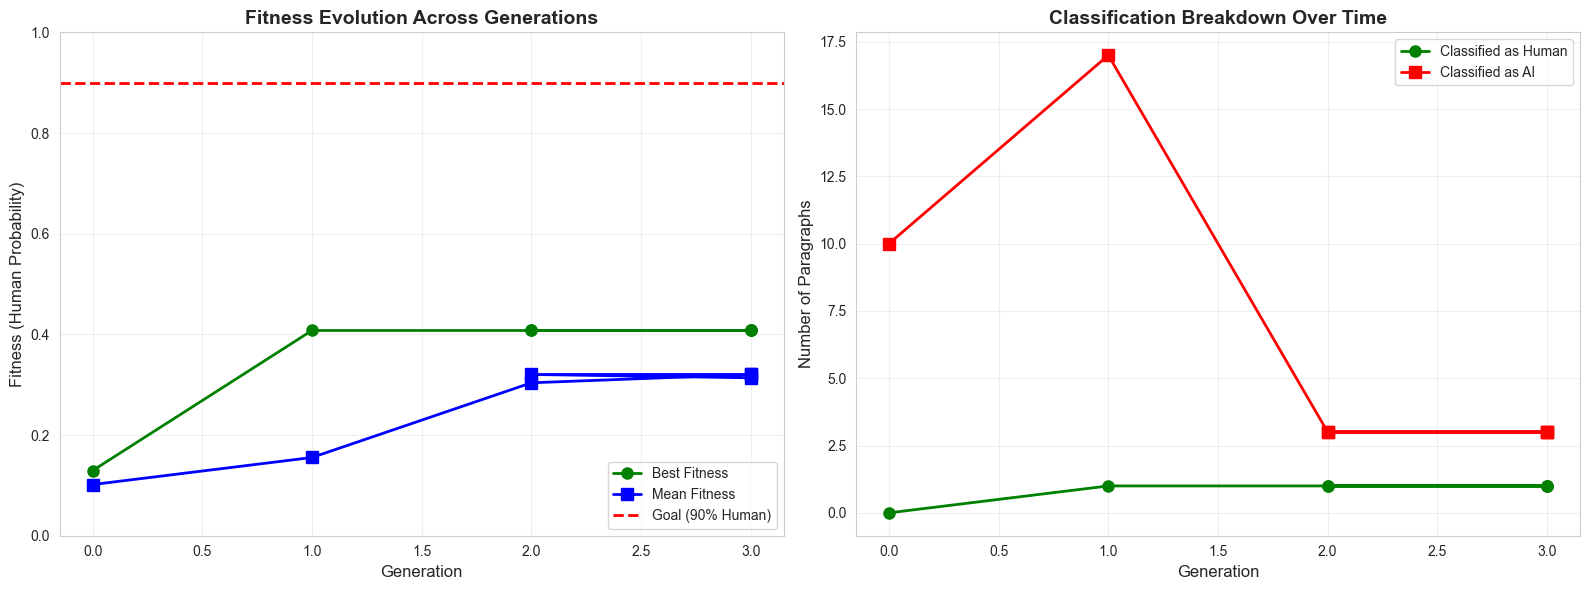


📈 Evolution Statistics:
Initial best fitness (Gen 0): 0.1294
Final best fitness (Gen 6): 0.4077
Total improvement: +0.2783 (+27.8 percentage points)

🎯 Goal not yet reached. Current best: 0.4077 (need 0.4923 more)


In [26]:
# Convert evolution history to DataFrame
evolution_df = pd.DataFrame(evolution_history)

print("📊 Evolution Summary:")
print("="*80)
print(evolution_df.to_string(index=False))
print("="*80)

# Plot fitness evolution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Fitness over generations
ax1 = axes[0]
ax1.plot(evolution_df['Generation'], evolution_df['Best_Fitness'], 
         marker='o', linewidth=2, markersize=8, label='Best Fitness', color='green')
ax1.plot(evolution_df['Generation'], evolution_df['Mean_Fitness'], 
         marker='s', linewidth=2, markersize=8, label='Mean Fitness', color='blue')
ax1.axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='Goal (90% Human)')
ax1.set_xlabel('Generation', fontsize=12)
ax1.set_ylabel('Fitness (Human Probability)', fontsize=12)
ax1.set_title('Fitness Evolution Across Generations', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Classification breakdown
ax2 = axes[1]
ax2.plot(evolution_df['Generation'], evolution_df['Human_Count'], 
         marker='o', linewidth=2, markersize=8, label='Classified as Human', color='green')
ax2.plot(evolution_df['Generation'], evolution_df['AI_Count'], 
         marker='s', linewidth=2, markersize=8, label='Classified as AI', color='red')
ax2.set_xlabel('Generation', fontsize=12)
ax2.set_ylabel('Number of Paragraphs', fontsize=12)
ax2.set_title('Classification Breakdown Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/ga_evolution.png', dpi=300, bbox_inches='tight')
print("\n✅ Evolution plot saved to: ../results/visualizations/ga_evolution.png")
plt.show()

# Summary statistics
print("\n📈 Evolution Statistics:")
print("="*80)
initial_best = evolution_df.iloc[0]['Best_Fitness']
final_best = evolution_df.iloc[-1]['Best_Fitness']
improvement = final_best - initial_best

print(f"Initial best fitness (Gen 0): {initial_best:.4f}")
print(f"Final best fitness (Gen {len(evolution_df)-1}): {final_best:.4f}")
print(f"Total improvement: {improvement:+.4f} ({improvement*100:+.1f} percentage points)")

if final_best >= 0.90:
    # Find which generation reached goal
    goal_gen = evolution_df[evolution_df['Best_Fitness'] >= 0.90].iloc[0]['Generation']
    print(f"\n🎉 Goal achieved in Generation {int(goal_gen)}!")
else:
    print(f"\n🎯 Goal not yet reached. Current best: {final_best:.4f} (need {0.90-final_best:.4f} more)")

print("="*80)

---

## (OPTIONAL) Step 16: Test Your Personal Writing

### 🎯 YOUR TURN!

**Test your SOP or any personal essay:**

1. Paste your text in the cell below
2. Run to see if detector thinks it's Human or AI
3. If AI: Try to humanize it manually
4. If Human: Try to make it sound more AI-like
5. Learn what linguistic patterns distinguish the two

In [35]:
# Paste your personal text here
my_text = """
It was two years ago when I first beheld the realm of deep learning—poor creature that I was! I knew nothing. The algorithms sprawled before me; their mathematics, inscrutable. But I endeavoured—oh how I strove!—to master them. Trial and error became my companions; optimization, my relentless pursuit. Yet one day, as I sat in my small study (the window overlooking the rain-soaked street), a thought struck me with peculiar force: efficiency alone was not enough! Nay—these machines must be aligned with human values, else what use were they? This realization changed everything; from that moment forth, my focus shifted entirely
"""

if my_text.strip() and "PASTE YOUR" not in my_text:
    # Evaluate
    fitness, probs = get_fitness(my_text)
    predicted_class = max(probs, key=probs.get)
    
    print("="*80)
    print("YOUR WRITING ANALYSIS")
    print("="*80)
    
    print(f"\n📝 Text preview: {my_text[:200]}...")
    
    print(f"\n🤖 DETECTOR VERDICT:")
    print(f"  Predicted class: {predicted_class}")
    print(f"  Confidence: {probs[predicted_class]*100:.2f}%")
    
    print(f"\n📊 All probabilities:")
    for label, prob in probs.items():
        bar = '█' * int(prob * 50)
        print(f"  {label:12s}: {prob*100:5.2f}% {bar}")


    print(f"\n💡 INTERPRETATION:")
    if predicted_class == 'Human' and probs['Human'] >= 0.90:
        print("  ✅ Your writing sounds authentically human!")
        print("  🎯 Challenge: Try to make it sound more 'AI-like'")
        print("     - Add corporate buzzwords")
        print("     - Make sentences more uniform")
        print("     - Use abstract concepts")
    elif predicted_class == 'Human':
        print("  ✅ Your writing leans human, but not strongly")
        print("  💪 You're in a good balance zone!")
    else:
        print("  ⚠️ Detector thinks your writing is AI-generated!")
        print("  🎯 Challenge: Try to humanize it")
        print("     - Vary sentence lengths")
        print("     - Add personal anecdotes")
        print("     - Use simpler, more direct language")
        print("     - Include conversational elements")
    
    print("\n" + "="*80)
else:
    print("⚠️ Please paste your text in the cell above and run again.")

YOUR WRITING ANALYSIS

📝 Text preview: 
It was two years ago when I first beheld the realm of deep learning—poor creature that I was! I knew nothing. The algorithms sprawled before me; their mathematics, inscrutable. But I endeavoured—oh h...

🤖 DETECTOR VERDICT:
  Predicted class: Human
  Confidence: 58.52%

📊 All probabilities:
  AI_Styled   : 32.45% ████████████████
  AI_Vanilla  :  9.03% ████
  Human       : 58.52% █████████████████████████████

💡 INTERPRETATION:
  ✅ Your writing leans human, but not strongly
  💪 You're in a good balance zone!



---

## 🎉 TASK 4 COMPLETE!

### What We Learned:

1. **Genetic Algorithm for Adversarial Testing**
   - Evolved AI text to bypass detector
   - Used 5 mutation strategies
   - Tracked fitness improvement over generations

2. **Detector Vulnerabilities** (from Tasks 3 & 4)
   - Structural patterns are primary signal
   - Buzzword detection is weak
   - Victorian vocabulary confuses the model
   - Can be fooled with strategic rewrites

3. **Human vs AI Writing**
   - Rhythm and variety matter
   - Simpler language often reads more "human"
   - Punctuation patterns are significant
   - Personal voice is hard to replicate

---

**Next:** Document findings in `REPORT.md`! 📝